<a href="https://colab.research.google.com/github/GergelyTuri/sleep/blob/master/notebooks/clustering/clustering_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

from google.colab import drive
drive.mount('/gdrive')

from os.path import join
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np
import pandas as pd
import seaborn as sns
from sleep.src import google_drive
from sleep.src import clustering

useful_data = google_drive.useful_datasets()

Cloning into 'sleep'...
remote: Enumerating objects: 1095, done.
remote: Counting objects: 100% (470/470), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 1095 (delta 290), reused 325 (delta 188), pack-reused 625
Receiving objects: 100% (1095/1095), 28.14 MiB | 11.44 MiB/s, done.
Resolving deltas: 100% (652/652), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=a40bb899cfe21d429e47f548162f0d5fe3cad8f2cd3f811298b80f89f4460212
  Stored in directory: /tmp/pip-ephem-wheel-cache-4xz5zxc0/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep
Mounted at /gdrive


In [2]:
!git pull

Already up to date.


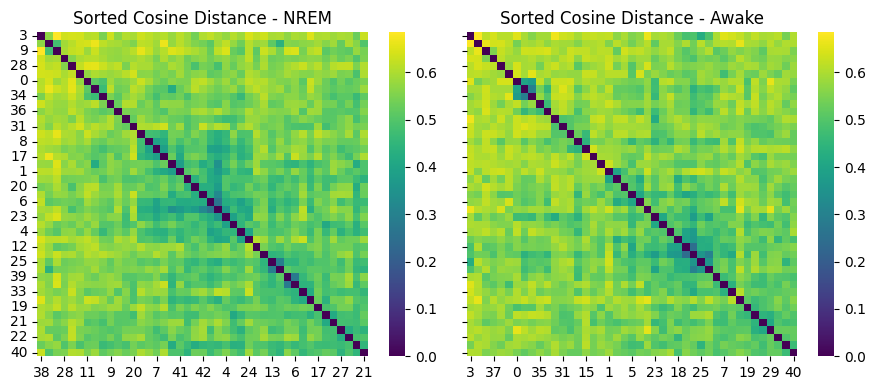

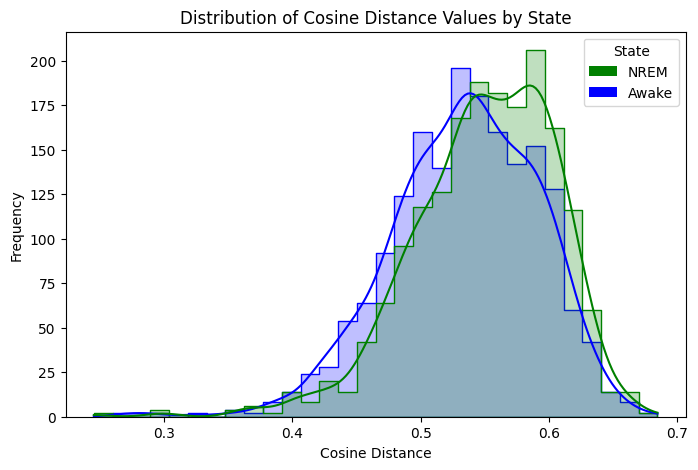

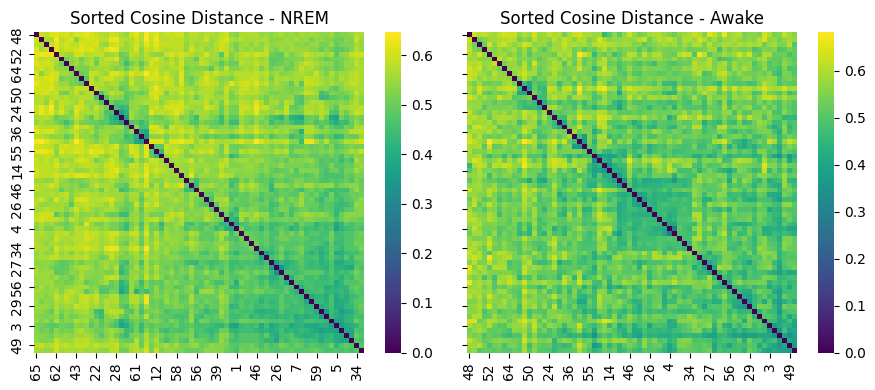

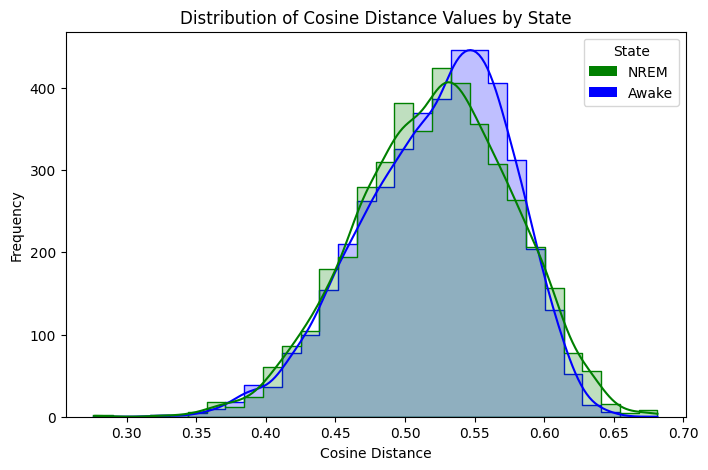

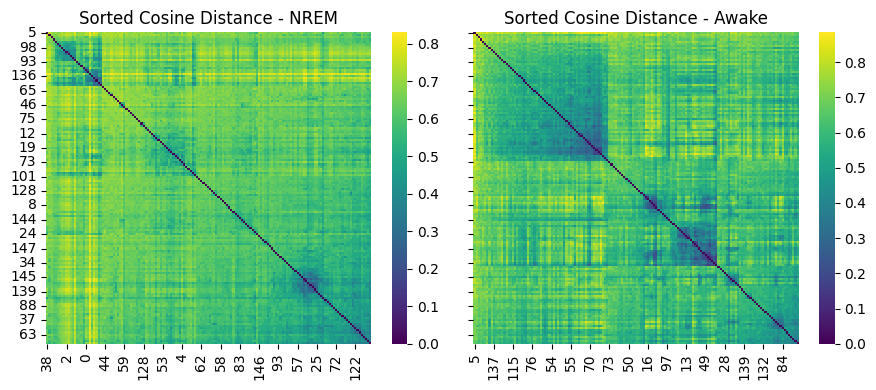

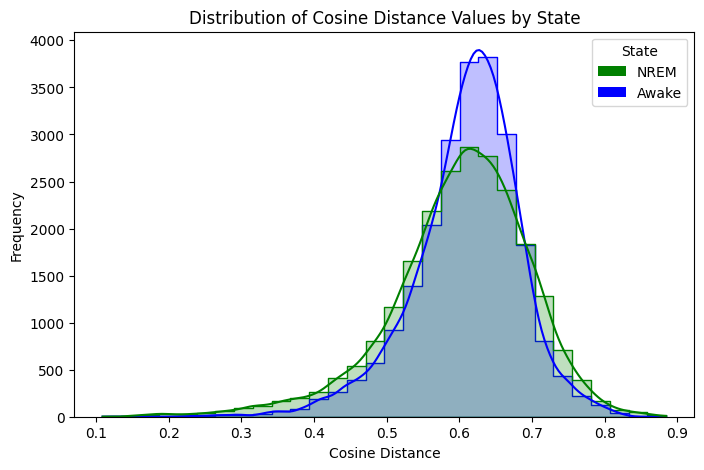

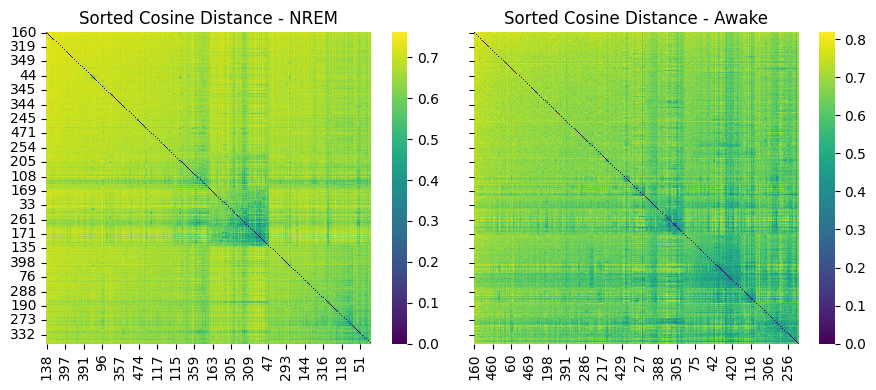

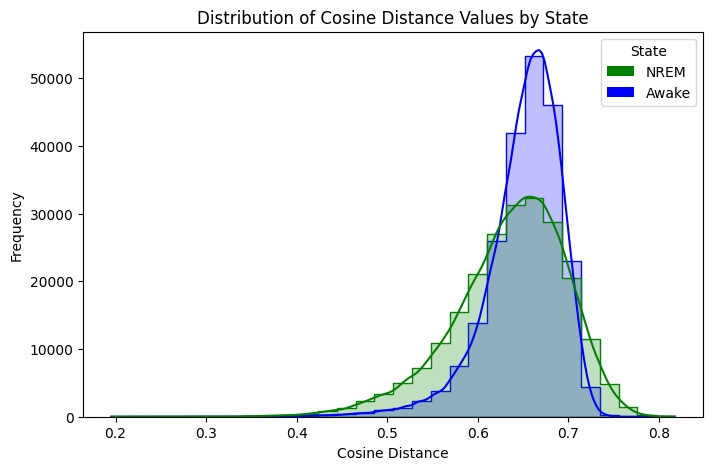

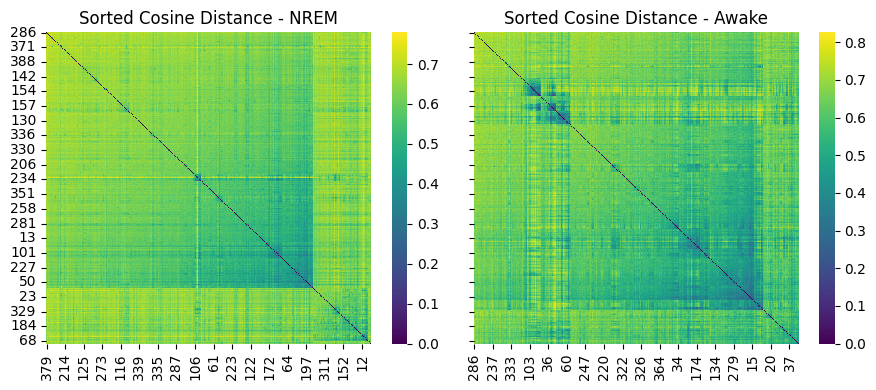

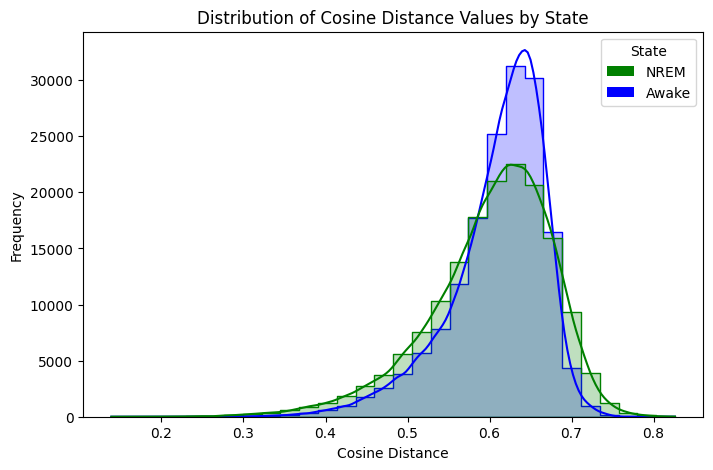

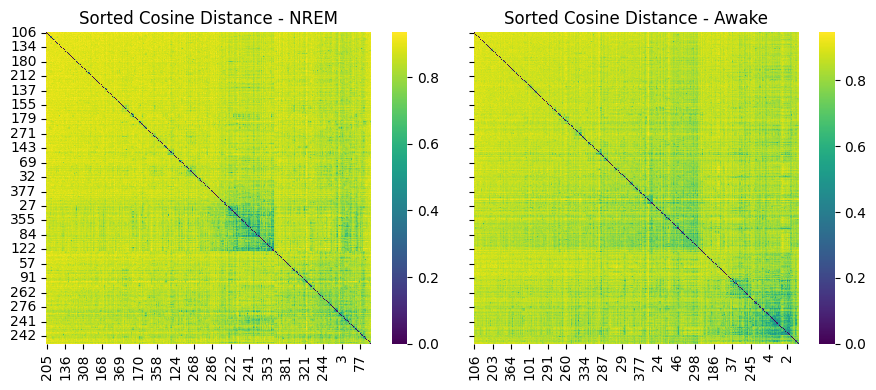

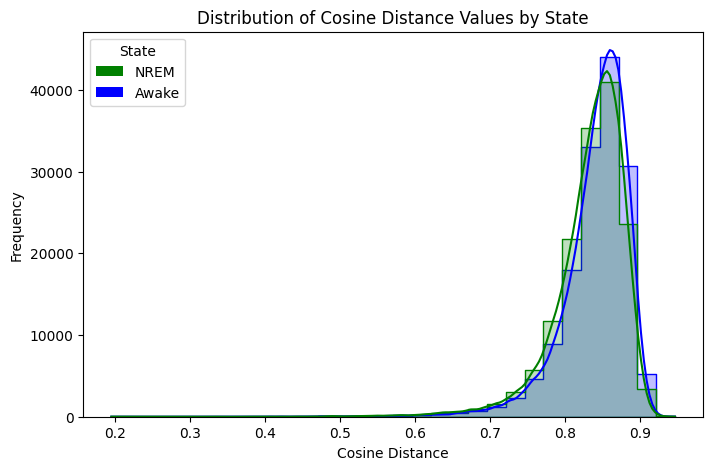

In [3]:
# Define experiment paths and corresponding file names
experiments = [
    ('5HT2afl05b_1', '7_12_SD2', 'TSeries-07122021-0901-002', 'velo_eeg.csv', 'dfof_mc.csv'),
    ('5HT2afl05b_2', '7_6_SD', 'TSeries-07062021-0844_MC2-004', 'velo_eeg.csv', 'dfof.csv'),
    ('126031_5', '11_23', 'TSeries-11232022-GC-MC-002', 'velo_eeg.csv', 'dfof.csv'),
    ('sert52b_1', '4_3_SD', 'TSeries-04032023-1323_SD_sess1-001', 'velo_eeg.csv', 'dfof.csv'),
    ('sert52b_5', '4_3_SD', 'TSeries-04032023-1323-001', 'velo_eeg.csv', 'dfof.csv'),
    ('sert54a_5', '4_4', 'TSeries-04042023-1023_sess1-001', 'velo_eeg.csv', 'dfof.csv')
]

# Iterate over experiments
for exp_id, exp_name, ts_name, eeg_file, dfof_file in experiments:
    exp_path = google_drive.return_exp_path(exp_id, exp_name, ts_name)
    processed_sleep_df = pd.read_csv(join(exp_path, 'eeg', eeg_file))
    file_name = dfof_file if 'mc' not in dfof_file else 'dfof_mc.csv'  # Adjust for different file naming
    dfof_data = pd.read_csv(join(exp_path, file_name))
    dfof_data.set_index('roi_label', drop=True, inplace=True)

    summary_sleep = clustering.df_generator(processed_sleep_df)
    result = clustering.process_dfof_mc(dfof_data, summary_sleep)
    d_awake = result['d_awake']
    d_sleep = result['d_sleep']
    cos_dist_nrem = clustering.calculate_cosine_distance(d_sleep, 'nrem', normalize=False)
    cos_dist_awake = clustering.calculate_cosine_distance(d_awake, 'awake', normalize=False)

    # Save cos_dist_nrem and cos_dist_awake to CSV files
    cos_dist_nrem.to_csv(join(exp_path, 'cos_dist_nrem.csv'), index=False)
    cos_dist_awake.to_csv(join(exp_path, 'cos_dist_awake.csv'), index=False)

    sorted_cos_dist_nrem = clustering.sort_distance_matrix(cos_dist_nrem)
    sorted_cos_dist_awake = clustering.sort_distance_matrix(cos_dist_awake)

    # Plot the sorted matrices using seaborn's heatmap function
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    sns.heatmap(sorted_cos_dist_nrem, ax=axs[0], cmap="viridis")
    axs[0].set_title("Sorted Cosine Distance - NREM")
    sns.heatmap(sorted_cos_dist_awake, ax=axs[1], cmap="viridis")
    axs[1].set_title("Sorted Cosine Distance - Awake")
    plt.tight_layout()

    # Saving the figure
    fig.savefig(join(exp_path, "MC_sorted_cosine_dist.png"), dpi=300)

    # Flatten the matrices and remove the diagonal (self-distance) values
    distance_values_nrem = cos_dist_nrem.values.flatten()
    distance_values_nrem = distance_values_nrem[~np.isnan(distance_values_nrem)]  # Remove NaN values if any
    distance_values_nrem = distance_values_nrem[distance_values_nrem != 0]  # Remove self-distances

    distance_values_awake = cos_dist_awake.values.flatten()
    distance_values_awake = distance_values_awake[~np.isnan(distance_values_awake)]  # Remove NaN values if any
    distance_values_awake = distance_values_awake[distance_values_awake != 0]  # Remove self-distances

    # Combine the distance values into a single array with an associated label array
    distance_values_combined = np.concatenate([distance_values_nrem, distance_values_awake])
    states_combined = ['NREM'] * len(distance_values_nrem) + ['Awake'] * len(distance_values_awake)

    # Create DataFrame
    distances_df = pd.DataFrame({
        'Cosine Distance': distance_values_combined,
        'State': states_combined
    })

    distances_df['State'] = distances_df['State'].astype('category')

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.histplot(
        data=distances_df,
        x='Cosine Distance',
        hue='State',
        kde=True,
        element='step',
        bins=30,
        palette=['green', 'blue']  # Explicitly set the palette here to match your desired colors
    )

    plt.title('Distribution of Cosine Distance Values by State')
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency')

    # Create custom legend handles with colors matching the plot
    legend_handles = [
        Patch(facecolor='green', label='NREM'),
        Patch(facecolor='blue', label='Awake')
    ]

    # Use the custom handles to create the legend, ensuring colors match the plot
    plt.legend(handles=legend_handles, title='State')

    # Saving the figure
    plt.savefig(join(exp_path, 'MC_distrib_cosine_distance_values.png'), dpi=300)

In [ ]:
from scipy.stats import ks_2samp

# Separate the distance values for each state
distance_values_nrem = distances_df[distances_df['State'] == 'NREM']['Cosine Distance']
distance_values_awake = distances_df[distances_df['State'] == 'Awake']['Cosine Distance']

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(distance_values_nrem, distance_values_awake)

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("The distributions of NREM and Awake states are statistically different.")
else:
    print("There is no significant difference in the distributions of NREM and Awake states.")


KS Statistic: 0.07973041370308215
P-value: 0.0
The distributions of NREM and Awake states are statistically different.
